In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# data
import numpy as np
import pandas as pd

# useful
import re, glob, os
from tqdm.auto import tqdm
from pathlib import Path

# misc
from scipy.spatial.distance import pdist
np.random.seed(3141519)

# Motivation

Packing circle is a common problem shows up in molecular modeling. For example, when we arrange lipid molecules in membrane bilayer, we are essentially packing circular areas in 2D box. One could use Monte-carlo simulation appraoch to pack these molecules, but it is a time consuming and compute intensive. Let's explore algorithmic ways to arrange these circles in 2D area, which will be an efficient approach.

Here, I'm going to follow the algorithm proposed by [Weixin Wang](https://dl.acm.org/doi/10.1145/1124772.1124851). In short, the algorithm attempt to add externally tangential circles to two circles that are already added. The algorithm uses so-called "front-chain", which holds the list of circles at the outer most edges and attempt to extend the chain. 

# Initial Circles

In [2]:
import math

n_circles = 1000
radii = [np.random.randint(1, 3) for i in range(n_circles)]

class Circle:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    
    @property
    def center(self):
        return (self.x, self.y)

For this excercise, let's try to add 100 circles with random radii. We defined a simple `Circle` class to hold information about circle.

First thing we will have to do is to lay out three initial circles. The first two circles are straightforward; first cicles is placed on the origin (0, 0) and the second circles is placed on the X-axis at $(r_0 + r_1, 0)$. 

In [3]:
# lay out initial circles
c1 = Circle(0, 0, radii[0])
c2 = Circle(radii[0] + radii[1], 0, radii[1])
circles = [c1, c2]
chain = [0, 1, 0]

The third circle is placed as tangent to the first two circles. To find the center of the third circle, we need to solve the systems of equation using the following relationship; $(x_3, y_3)$ is distance of $(r_1 + r_3)$ from the center of the first circle and $(x_3, y_3)$ is distance of $(r_2 + r_3)$ from the center of the second circle.

$
(x_3 - x_1)^2 + (y_3 - y_1)^2 = (r_1 + r_3)^2 \\
(x_3 - x_2)^2 + (y_3 - y_2)^2 = (r_2 + r_3)^2
$

This can be done trivially using `sympy` package

In [4]:
import sympy
from sympy import solve_poly_system
from sympy.abc import x, y

In [5]:
def tangent_circle_sympy(c1, c2, r3):
    x1, y1, r1 = c1.x, c1.y, c1.r
    x2, y2, r2 = c2.x, c2.y, c2.r
    r1 += r3
    r2 += r3
    
    eq1 = sympy.Eq((x - x1)**2 + (y - y1)**2, r1**2)
    eq2 = sympy.Eq((x - x2)**2 + (y - y2)**2, r2**2)
    p3 = solve_poly_system([eq1, eq2], x, y)
    return p3

In [6]:
tangent_circle_sympy(c1, c2, radii[2])

[(1, -2*sqrt(2)), (1, 2*sqrt(2))]

Analytically, an externally tangent circle, $C_C$ to the two circles (tangent to each other), $C_A$ and $C_B$, can be found by finding an intersection point of two circles having same center as $C_A$ and $C_B$ but larger radii $r_A + r_C$ and $r_B + r_C$.

![feature](files/circle_tangent.png)

The detailed derivation on how to find the intersection points can be found in Paul Bourke's note: http://paulbourke.net/geometry/circlesphere/

In [7]:
from math import sqrt

def tangent_circle(c0, c1, r):
    r0 = c0.r + r
    r1 = c1.r + r
    x0, y0 = c0.center
    x1, y1 = c1.center
    
    d = sqrt((x0 - x1)**2 + (y0 - y1)**2)
    a = (r0*r0 - r1*r1 + d*d) / (2 * d)
    h = sqrt(r0*r0 - a*a)
    
    x2 = x0 + a * (x1 - x0) / d
    y2 = y0 + a * (y1 - y0) / d
    
    p3 = (
        (x2 + h * (y1 - y0) / d, y2 - h * (x1 - x0) / d),
        (x2 - h * (y1 - y0) / d, y2 + h * (x1 - x0) / d)
    )
    
    theta1 = math.atan2(p3[0][1]-y0, p3[0][0]-x0)
    theta2 = math.atan2(p3[1][1]-y0, p3[1][0]-x0)
    if theta2 > theta1:
        p3 = (p3[1], p3[0])
        
    return p3

In [8]:
p3 = tangent_circle(c1, c2, radii[2])
print(p3)

((1.0, 2.8284271247461903), (1.0, -2.8284271247461903))


Either approach works, but the latter will run faster, so we will use the analytical function. 

Now, let's add the third circle and visualize the circles as well as the "front-chain".

In [9]:
c3 = Circle(p3[0][0], p3[0][1], radii[2])
circles = [c1, c2, c3]
chain = [0, 1, 2, 0]

In [10]:
#collapse-hide
def draw_circles(circles, circle_chain=[], show_label=False):
    fig, ax = plt.subplots(figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
    xmin, xmax = 999, -999
    ymin, ymax = 999, -999

    for i, c in enumerate(circles):
        patch = plt.Circle(c.center, c.r, color='gray')
        if c.x - c.r < xmin: xmin = c.x - c.r
        if c.x + c.r > xmax: xmax = c.x + c.r
        if c.y - c.r < ymin: ymin = c.y - c.r
        if c.y + c.r > ymax: ymax = c.y + c.r
        ax.add_patch(patch)
        if show_label:
            ax.text(c.x - 0.1, c.y - 0.1, f'C_{i}')
        
    line_x = [circles[idx].x for idx in circle_chain]
    line_y = [circles[idx].y for idx in circle_chain]
    ax.plot(line_x, line_y, marker='o')

    xwidth = xmax - xmin
    ywidth = ymax - ymin
    xcenter = xmin + xwidth / 2
    ycenter = ymin + ywidth / 2
    xwidth = ywidth = max(xwidth, ywidth)
    
    ax.set_xlim(xcenter - xwidth / 2, xcenter + xwidth / 2)
    ax.set_ylim(ycenter - ywidth / 2, ycenter + ywidth / 2)
    plt.show()

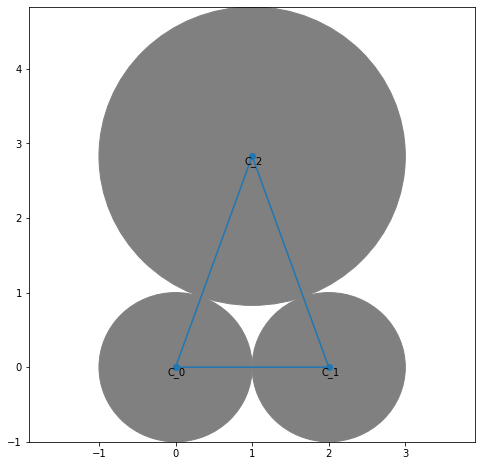

In [11]:
draw_circles(circles, chain, show_label=True)

# Add more circles

Let's add more circles and update front-chain according to the algorithm described in paper. Following is quoted verbatim from the paper.

1) Calculate the center of $C_i$ according to the radius $r_i$ and the tangency of circle $C_i$ to $C_m$ and $C_n$. The circles $C_m$ and $C_n$ are the circles next to each other in the front-chain. 

2) Search the front-chain and find out the circle $C_j$ intersecting with $C_i$. 

3) If $C_i$ does not intersect with any circle $C_j$ in the front-chain, $C_i$ is added to the front-chain directly, and packing $C_i$ is terminated. The front-chain is updated to include $C_i$, such that $\{\cdots C_m \leftrightarrow C_n \cdots\}$ becomes $\{\cdots C_m \leftrightarrow C_i \leftrightarrow C_n \cdots\}$

4) If $C_i$ intersects with $C_j$, and $C_j$ is a circle after $C_n$ on the front-chain, then the segments from $C_m$ to $C_j$ have to be deleted from the front-chain and the circle $C_n$ is replaced by $C_j$. Go to step 1. A new position of $C_i$ tangent to the two circles $C_m$ and $C_n$ will be calculated.

5) If $C_i$ intersects with $C_j$, and $C_j$ is a circle before $C_m$ on the front-chain, then the segments from $C_j$ to $C_m$ have to be deleted from the front-chain and the circle $C_m$ is replaced by $C_j$. Go to step 1. A new position of $C_i$ tangent to the two circles $C_m$ and $C_n$ will be calculated.

In [12]:
#collapse-hide
def circle_intersect(circle1, circle2, test_only=False):
    """
    Intersection points of two circles using the construction of triangles
    as proposed by Paul Bourke, 1997.
    http://paulbourke.net/geometry/circlesphere/
    """

    x0, y0 = circle1.x, circle1.y
    x1, y1 = circle2.x, circle2.y
    r0 = circle1.r
    r1 = circle2.r

    d = sqrt((x0 - x1)**2 + (y0 - y1)**2)
    if d > (r0 + r1):
        return -1, None # do not intersect
    elif d <= abs(r1 - r0):
        return -2, None # one circle is contained within the circle

    if d == (r0 + r1) or d == (r0 - r1):
        CASE = 1
    else:
        CASE = 2
    
    if test_only:
        return CASE, None

    a = (r0*r0 - r1*r1 + d*d) / (2 * d)
    h = sqrt(r0*r0 - a*a)

    x2 = x0 + a * (x1 - x0) / d
    y2 = y0 + a * (y1 - y0) / d

    I1 = (x2 + h * (y1 - y0) / d, y2 - h * (x1 - x0) / d)
    if CASE == 1:
        return CASE, (I1,)

    I2 = (x2 - h * (y1 - y0) / d, y2 + h * (x1 - x0) / d)

    theta1 = math.degrees(math.atan2(I1[1]-y0, I1[0]-x0))
    theta2 = math.degrees(math.atan2(I2[1]-y0, I2[0]-x0))
    if theta2 > theta1:
        I1, I2 = I2, I1
    return CASE, (I1, I2)
    
def tangent_circle_center(circle1, circle2, radius3):
    """
    find center of circle tangent to both circle1 and circle2
    
    circle1 and circle2 is assumed to be tangent
    """

    x0, y0 = circle1.x, circle1.y
    x1, y1 = circle2.x, circle2.y
    r0 = circle1.r + radius3
    r1 = circle2.r + radius3

    d = sqrt((x0 - x1)**2 + (y0 - y1)**2)
    a = (r0*r0 - r1*r1 + d*d) / (2 * d)
    h = sqrt(r0*r0 - a*a)

    x2 = x0 + a * (x1 - x0) / d
    y2 = y0 + a * (y1 - y0) / d

    I1 = (x2 + h * (y1 - y0) / d, y2 - h * (x1 - x0) / d)
    I2 = (x2 - h * (y1 - y0) / d, y2 + h * (x1 - x0) / d)

    torque = (x1-x0)*(I1[1]-y0)-(y1-y0)*(I1[0]-x0)
    if torque > 0:
        I1, I2 = I2, I1
    return I1, I2

    theta1 = math.atan2(I1[1]-y0, I1[0]-x0)
    theta2 = math.atan2(I2[1]-y0, I2[0]-x0)
    if theta2 > theta1:
        pass
        
    print(theta2, theta1)
    return I1, I2

In [54]:
def add_circle(circles, chain, index, radius):
    c_m = circles[chain[index]]
    c_n = circles[chain[index+1]]
    
    while 1:
        p3 = tangent_circle_center(c_m, c_n, radius)
        c_i = Circle(p3[0][0], p3[0][1], radius)

        update = False
        for i, idx in enumerate(chain[:-1]):
            if i == index or i == index+1:
                continue
            if i == 0 and index + 1 == len(chain) - 1:
                continue

            c_j = circles[idx]
            CASE, _ = circle_intersect(c_i, c_j, test_only=True)
            if CASE > 1:
                distance_left = index - i if index - i > 0 else index - i + len(chain) - 1
                distance_right = i - index - 1 if i - index - 1 > 0 else i - index - 1 + len(chain) - 1
                left = distance_left < distance_right
                
                #print(left, chain, chain[index], chain[i], i, index)
                    
                if left:
                    if i < index:
                        chain = chain[:i+1] + chain[index+1:]
                    else:
                        chain = chain[i:] + chain[index+1:i] + [chain[i]]
                else:
                    if i > index:
                        chain = chain[:index+1] + chain[i:]
                    else:
                        chain = chain[i:index+1] + [chain[i]]
                    
                if index > len(chain) - 2:
                    index = 0
                    
                #print(chain)
                c_m = circles[chain[index]]
                c_n = circles[chain[index+1]]
                update = True
                break
            
        if update:
            continue
        
        circles.append(c_i)
        chain = chain[:index+1] + [len(circles)-1] + chain[index+1:] 
        return circles, chain

Now we can repeatedly call above function to add circles to our 

In [18]:
c3 = Circle(p3[0][0], p3[0][1], radii[2])
circles = [c1, c2, c3]
chain = [0, 1, 2, 0]
index = 0

for i in range(100):
    circles, chain = add_circle(circles, chain, index, radii[3 + i])
    index += 1
    if index > len(chain) - 2:
        index = 0

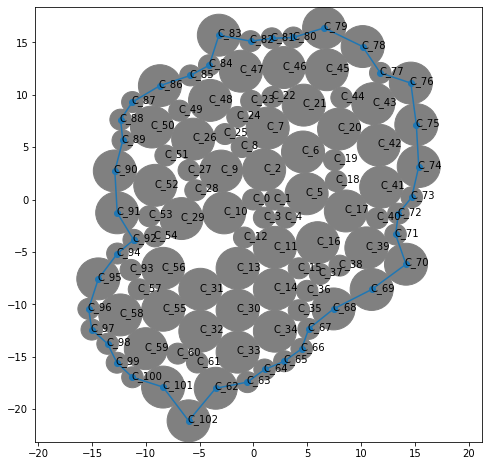

In [56]:
draw_circles(circles, chain, show_label=True)

And here's a little animation of the process.

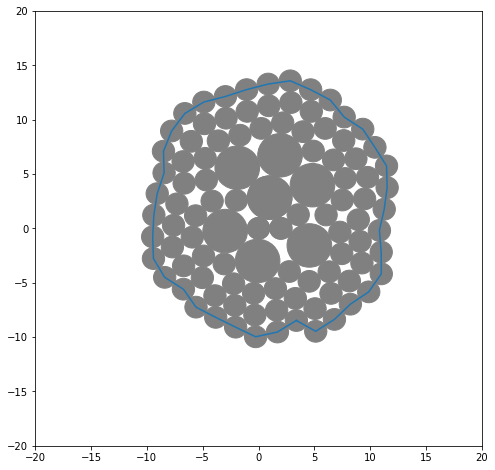

In [57]:
#collapse-hide
"""
A simple example of an animated plot
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
xmin, xmax = 999, -999
ymin, ymax = 999, -999

line, = ax.plot([], [])

c3 = Circle(p3[0][0], p3[0][1], radii[2])
circles = [c1, c2, c3]
chain = [0, 1, 2, 0]
index = 0

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

def animate(index):
    global circles, chain
    if index > len(chain) - 2:
        index = 0
        
    circles, chain = add_circle(circles, chain, index, radii[3 + index])

    #line.set_xdata(circles[-1].x)
    #line.set_ydata(circles[-1].y)
    
    patch = plt.Circle(circles[-1].center, circles[-1].r, color='gray')
    ax.add_patch(patch)
    
    x = []
    y = []
    
    for idx in chain:
        x.append(circles[idx].x)
        y.append(circles[idx].y)
        
    x.append(circles[chain[0]].x)
    y.append(circles[chain[0]].y)
        
    line.set_data(x, y)
    return line,

#Init only required for blitting to give a clean slate.
def init():
    x = []
    y = []
    
    for i in range(3):
        patch = plt.Circle(circles[i].center, circles[i].r, color='gray')
        ax.add_patch(patch)
        x.append(circles[i].x)
        y.append(circles[i].y)
        
    x.append(circles[0].x)
    y.append(circles[0].y)
        
    line.set_data(x, y)
    return line,

#ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
#    interval=25, blit=False)

ani = animation.FuncAnimation(fig, animate, np.arange(1, 100), interval=350, 
                              init_func=init, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())